# Transfer Cell 2 Pack
## Compare the Cell pOCV, DVA and ICA with the DVA from the vehicles VW and Tesla
## aligned by the lower cut-off voltage

In [1]:
import os
import sys
import math
sys.path.append(os.getcwd().partition('notebooks')[0])
from src.config_base import GeneralConfig

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator, FixedLocator

In [3]:
from src.data.read_pickle import ReadPickle
from src.filtering.filter_methods import FilterMethods
from src.voltage_capacity_analysis.ica import ICA
from src.voltage_capacity_analysis.dva import DVA
from src.visualization.config_visualization import VisualizationConfig, instantiate_matplotlib_parameters, cm2inch
instantiate_matplotlib_parameters()
from src.visualization.colormaps import ColorMaps

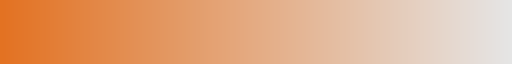

In [4]:
tum_orange_cmap = ColorMaps.orange_tum()
orange_colors = tum_orange_cmap(np.linspace(0,1, 10))
tum_orange_cmap

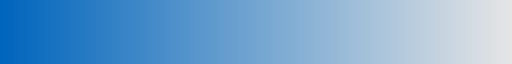

In [5]:
tum_blue_cmap = ColorMaps.blue_tum()
blue_colors = tum_blue_cmap(np.linspace(0,1, 10))
tum_blue_cmap

## Read VW Cell File

In [6]:
path2files = os.path.join(GeneralConfig.path2data.value,"VW","cell")

In [7]:
def filter_func_preprocess_U(signal):
    perc_filter = 0.1/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [8]:
def filter_func_preprocess_Q(signal):
    perc_filter = 0.1/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [9]:
read_pickle = ReadPickle()
read_pickle.set_filter_U(filter_func_preprocess_U)
read_pickle.set_filter_Q(filter_func_preprocess_Q)

In [10]:
df_cell_vw =  read_pickle.read(os.path.join(path2files,"VW_LG_78Ah_NMC_20deg_CP_C45.pkl"))

In [11]:
def filter_func(signal):
    perc_filter = 0.5 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [12]:
dva_extractor = DVA()
dva_extractor.set_filter(filter_func)
dva_cell_vw, cap_cell_vw =dva_extractor.get_dva(time=df_cell_vw["time_h"], capacity=df_cell_vw["Q"], voltage=df_cell_vw["U"],crop_cap_Ah=(0,79.5))

In [13]:
ica_extractor = ICA()
ica_extractor.set_filter(filter_func)
ica_cell_vw, volt_cell_vw =ica_extractor.get_ica(time=df_cell_vw["time_h"], capacity=df_cell_vw["Q"], voltage=df_cell_vw["U"],crop_volt_V=(2.8,4.2))

## Read VW Vehicle Files

In [14]:
path2files_vw = os.path.join(GeneralConfig.path2data.value,"VW","vehicle")

In [15]:
def filter_func_preprocess_v_U(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [16]:
def filter_func_preprocess_v_Q(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [17]:
read_pickle = ReadPickle()
read_pickle.set_filter_U(filter_func_preprocess_v_U)
read_pickle.set_filter_Q(filter_func_preprocess_v_Q)

In [18]:
df_vw =  read_pickle.read(os.path.join(path2files_vw,"VW_ID3_JB_8A_C40_2021.pkl"))

In [19]:
df_vw["U"].min()

359.30385781303863

In [20]:
def filter_func_v(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [21]:
dva_extractor = DVA()
dva_extractor.set_filter(filter_func_v)

In [22]:
dva_vw, cap_vw =dva_extractor.get_dva(time=df_vw["time_h"], capacity=df_vw["Q"], voltage=df_vw["U"],crop_cap_Ah=(1,180))

In [23]:
deltaQ_vw =  dva_extractor.get_Q_shift_for_lower_cut_off_voltage(df_vehicle = df_vw, df_cell = df_cell_vw,n_seriell=108,n_parallel=2)

In [24]:
deltaQ_vw

6.379358561700205

In [25]:
ica_extractor = ICA()
ica_extractor.set_filter(filter_func_v)
ica_extractor.set_post_filter(filter_func_v)
ica_vw, volt_vw =ica_extractor.get_ica(time=df_vw["time_h"], capacity=df_vw["Q"], voltage=df_vw["U"],crop_volt_V=(360,500))

## Read Tesla Cell File

In [26]:
path2files = os.path.join(GeneralConfig.path2data.value,"Tesla","cell")

In [27]:
def filter_func_preprocess_U(signal):
    perc_filter = 0.1/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [28]:
def filter_func_preprocess_Q(signal):
    perc_filter = 0.1/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [29]:
read_pickle = ReadPickle()
read_pickle.set_filter_U(filter_func_preprocess_U)
read_pickle.set_filter_Q(filter_func_preprocess_Q)

In [30]:
df_cell_tesla =  read_pickle.read(os.path.join(path2files,"Tesla_CATL_161Ah_LFP_20deg_C57.pkl"))

### Tesla Cell DVA/ICA

In [31]:
def filter_func(signal):
    perc_filter = 0.5 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [32]:
dva_extractor = DVA()
dva_extractor.set_filter(filter_func)
dva_cell_tesla, cap_cell_tesla =dva_extractor.get_dva(time=df_cell_tesla["time_h"], capacity=df_cell_tesla["Q"], voltage=df_cell_tesla["U"],crop_cap_Ah=(0,180))

In [33]:
ica_extractor = ICA()
ica_extractor.set_filter(filter_func)
ica_cell_tesla, volt_cell_tesla =ica_extractor.get_ica(time=df_cell_tesla["time_h"], capacity=df_cell_tesla["Q"], voltage=df_cell_tesla["U"],crop_volt_V=(2.6,3.6))

## Read Tesla Vehicle Files

In [34]:
path2files_tesla = os.path.join(GeneralConfig.path2data.value,"Tesla","vehicle")

In [35]:
def filter_func_preprocess_v_U(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [36]:
def filter_func_preprocess_v_Q(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [37]:
read_pickle = ReadPickle()
read_pickle.set_filter_U(filter_func_preprocess_v_U)
read_pickle.set_filter_Q(filter_func_preprocess_v_Q)

In [38]:
df_tesla =  read_pickle.read(os.path.join(path2files_tesla,"Tesla_JB_8A_CEE7_C57_2022.pkl"))

In [39]:
df_tesla["U"].max()

367.91735086952457

In [40]:
def filter_func_v(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [41]:
dva_extractor = DVA()
dva_extractor.set_filter(filter_func_v)

In [42]:
dva_tesla, cap_tesla = dva_extractor.get_dva(time=df_tesla["time_h"], capacity=df_tesla["Q"], voltage=df_tesla["U"],crop_cap_Ah=(1,180))

In [43]:
deltaQ_tesla =  dva_extractor.get_Q_shift_for_lower_cut_off_voltage(df_vehicle = df_tesla, df_cell = df_cell_tesla,n_seriell=106,n_parallel=1)

In [44]:
deltaQ_tesla

4.9751308972825745

In [45]:
ica_extractor = ICA()
ica_extractor.set_filter(filter_func_v)
ica_extractor.set_post_filter(filter_func_v)
ica_tesla, volt_tesla = ica_extractor.get_ica(time=df_tesla["time_h"], capacity=df_tesla["Q"], voltage=df_tesla["U"],crop_volt_V=(280,390),postfilter=True,postfilter_volt_range=(350,360))

## Plot

In [46]:
def myround(x, prec=2, base=.05):
    return round(base * round(float(x)/base),prec)

In [47]:
def plot_pOCV_vw(axes,
          cap_cell, U_cell,
          cap_vehicle, U_vehicle,
          lst_Q_shift_factor):
    
    sec_ax = axes.twinx()
    axes.set_zorder(sec_ax.get_zorder()+1)  # default zorder is 0 for ax1 and ax2
    axes.patch.set_visible(False)  # prevents ax1 from hiding ax2
    Q_nom = 78
    axes.plot(cap_cell*2,U_cell*108,color = VisualizationConfig.TUMblau.value,linewidth=2) # shitty solver for gridlines overlaying secaxis
    axes.plot(cap_vehicle+lst_Q_shift_factor,U_vehicle,color=VisualizationConfig.TUMorange.value,linewidth=2)
    
    axes.set_ylabel(r"Vehicle voltage in V",fontsize=9)
    axes.set_xlabel(r"Vehicle charge in Ah",fontsize=9) 
    axes.set_xlim([0,160])
    tick_positions = np.array([0,40,80,120,156])
    axes.set_xticks(tick_positions)
    axes.set_ylim([303,455])#456
    tick_positions = np.array(list(range(303,456,38)))
    axes.set_yticks(tick_positions)
    axes.grid(axis='both')
    # Minor X-axis divided into 10 parts between each X-axis major grid
    axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    axes.set_axisbelow(True)
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=True, labelright=False)
    axes.tick_params(axis='x', labelsize=9)
    axes.tick_params(axis='y', labelsize=9)
    
    
    sec_ax.plot(cap_cell*2,U_cell,color = VisualizationConfig.TUMblau.value,linewidth=2)

    sec_ax.set_xlim([0,160])
    sec_ax.set_ylim([303/108,455/108])
    tick_labels = np.array(list(range(303,456,38)))/108
    sec_ax.set_yticks(tick_labels)
    sec_ax.set_yticklabels([f"{myround(label):.2f}" for label in tick_labels])
    sec_ax.tick_params(axis='y', labelsize=9)
    
    # sec_ax.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    # sec_ax.tick_params('y', left=True, labelleft=False,right=True, labelright=True)
    sec_ax.set_ylabel(r"Cell voltage in V",fontsize=9)
    
    # axes.get_yaxis().set_label_coords(-0.16,0.5)
    # sec_ax.get_yaxis().set_label_coords(1.16,0.5)
    
    twiny = axes.twiny()
    twiny.set_xlabel(r"$\bf{VW\ ID.3\ Pro\ Performance}$"+"\n"+"Cell charge in Ah",fontsize=9) 
    twiny.set_xlim(0,80)
    tick_positions = np.array([0,20,40,60,78])
    twiny.set_xticks(tick_positions)
    # Minor X-axis divided into 10 parts between each X-axis major grid
    twiny.xaxis.set_minor_locator(FixedLocator([10,30,50,70]))
    twiny.tick_params(axis='x', labelsize=9)
    return axes

In [48]:
def plot_pOCV_tesla(axes,
          cap_cell, U_cell,
          cap_vehicle, U_vehicle,
          lst_Q_shift_factor):
    
    sec_ax = axes.twinx()
    axes.set_zorder(sec_ax.get_zorder()+1)  # default zorder is 0 for ax1 and ax2
    axes.patch.set_visible(False)  # prevents ax1 from hiding ax2
    Q_nom = 161
    axes.plot(cap_cell,U_cell*106,color = VisualizationConfig.TUMblau.value,linewidth=2)
    axes.plot(cap_vehicle+lst_Q_shift_factor,U_vehicle,color=VisualizationConfig.TUMorange.value,linewidth=2)
    axes.set_ylabel(r"Vehicle voltage in V",fontsize=9)
    axes.set_xlabel(r"Vehicle charge in Ah",fontsize=9) 
    axes.set_xlim([0,166])
    tick_positions = np.array([0,40,80,120,161])
    axes.set_xticks(tick_positions)
    axes.set_ylim([278,382])
    tick_positions = np.array(list(range(278,383,26)))
    axes.set_yticks(tick_positions)
    axes.grid(axis='both')
    axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    axes.set_axisbelow(True)
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=True, labelright=False)
    axes.tick_params(axis='x', labelsize=9)
    axes.tick_params(axis='y', labelsize=9)
    
    sec_ax.plot(cap_cell,U_cell,color = VisualizationConfig.TUMblau.value,linewidth=2)

    sec_ax.set_xlim([0,166])
    sec_ax.set_ylim([278/106,382/106])
    tick_labels = np.array(list(range(278,383,26)))/106
    sec_ax.set_yticks(tick_labels)
    sec_ax.set_yticklabels([f"{myround(label):.2f}" for label in tick_labels])
    sec_ax.tick_params(axis='y', labelsize=9)
    # sec_ax.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    # sec_ax.tick_params('y', left=True, labelleft=False,right=True, labelright=True)
    sec_ax.set_ylabel(r"Cell voltage in V",fontsize=9)
    
    # axes.get_yaxis().set_label_coords(-0.16,0.5)
    # sec_ax.get_yaxis().set_label_coords(1.16,0.5)

    twiny = axes.twiny()
    twiny.set_xlabel(r"$\bf{Tesla\ Model\ 3\ Standard\ Range\ Plus}$"+"\n"+"Cell charge in Ah",fontsize=9) 
    twiny.set_xlim(0,166)
    tick_positions = np.array([0,40,80,120,161])
    twiny.set_xticks(tick_positions)
    twiny.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    twiny.tick_params(axis='x', labelsize=9)
    return axes

In [49]:
def plot_dva_vw(axes,
                  cap_cell, dva_cell,
                  cap_v, dva_v,
                  shift_factor):

    sec_ax = axes.twinx()
    axes.set_zorder(sec_ax.get_zorder()+1)  # default zorder is 0 for ax1 and ax2
    axes.patch.set_visible(False)  # prevents ax1 from hiding ax2
    Q_nom = 78
    axes.plot(2*cap_cell,dva_cell*Q_nom*108,color=VisualizationConfig.TUMblau.value)
    axes.plot(cap_v+shift_factor,dva_v*Q_nom*2,color=VisualizationConfig.TUMorange.value)

    axes.set_ylabel(r"$Q_{veh.}\cdot \frac{dU_{veh.}}{dQ_{veh.}}$ in V",fontsize=9)
    axes.set_xlabel(r"Vehicle charge in Ah",fontsize=9) 
    axes.set_xlim([0,160])
    axes.set_ylim([0,216])
    tick_positions =np.array([0,54,108,162,216])
    axes.set_yticks(tick_positions)
    tick_positions = np.array([0,40,80,120,156])
    axes.set_xticks(tick_positions)
    axes.grid(axis='both')
    axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    axes.set_axisbelow(True)
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=True, labelright=False)
    axes.tick_params(axis='x', labelsize=9)
    axes.tick_params(axis='y', labelsize=9)
    
    sec_ax.plot(2*cap_cell,dva_cell*Q_nom,color=VisualizationConfig.TUMblau.value)
    sec_ax.set_xlim([0,160])
    sec_ax.set_ylim([0,216/108])
 
    tick_positions =np.array([0,40,80,120,156])
    sec_ax.set_xticks(tick_positions)
    
    sec_ax.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    
    sec_ax.tick_params('y', left=True, labelleft=False,right=True, labelright=True)
    sec_ax.set_ylabel(r"$Q_{cell}\cdot \frac{dU_{cell}}{dQ_{cell}}$ in V",fontsize=9)
    tick_labels = np.array([0,54,108,162,216])/108
    sec_ax.set_yticks(tick_labels)
    #sec_ax.set_yticklabels([f"{label:.2f}" for label in tick_labels])
    sec_ax.set_yticklabels(["0","0.50","1.00","1.50","2.00"])
    sec_ax.tick_params(axis='y', labelsize=9)
    
    # axes.get_yaxis().set_label_coords(-0.16,0.5)
    # sec_ax.get_yaxis().set_label_coords(1.16,0.5)
    
    twiny = axes.twiny()
    twiny.set_xlabel(r"Cell charge in Ah",fontsize=9) 
    twiny.set_xlim(0,80)
    tick_positions = np.array([0,20,40,60,78])
    twiny.set_xticks(tick_positions)
    # Minor X-axis divided into 10 parts between each X-axis major grid
    twiny.xaxis.set_minor_locator(FixedLocator([10,30,50,70]))
    twiny.tick_params(axis='x', labelsize=9)
 
    return axes

In [50]:
def plot_dva_tesla(axes,
                  cap_cell, dva_cell,
                  cap_v, dva_v,
                  shift_factor):

    sec_ax = axes.twinx()
    axes.set_zorder(sec_ax.get_zorder()+1)  # default zorder is 0 for ax1 and ax2
    axes.patch.set_visible(False)  # prevents ax1 from hiding ax2
    Q_nom = 161
    axes.plot(cap_cell,dva_cell*Q_nom*106,color=VisualizationConfig.TUMblau.value)
    axes.plot(cap_v+shift_factor,dva_v*Q_nom,color=VisualizationConfig.TUMorange.value)

    axes.set_ylabel(r"$Q_{veh.}\cdot \frac{dU_{veh.}}{dQ_{veh.}}$ in V",fontsize=9)
    axes.set_xlabel(r"Vehicle charge in Ah",fontsize=9) 
    axes.set_xlim([0,166])
    axes.set_ylim([0,106])
    tick_positions =np.array([0,27,54,81,106])
    axes.set_yticks(tick_positions)
    tick_positions = np.array([0,40,80,120,161])
    axes.set_xticks(tick_positions)
    axes.grid(axis='both')
    axes.set_axisbelow(True)
    axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=True, labelright=False)
    axes.tick_params(axis='x', labelsize=9)
    axes.tick_params(axis='y', labelsize=9)
    
    sec_ax.plot(cap_cell,dva_cell*Q_nom,color=VisualizationConfig.TUMblau.value)
    sec_ax.set_xlim([0,166])
    sec_ax.set_ylim([0,106/106])
 
    tick_positions = np.array([0,40,80,120,161])
    sec_ax.set_xticks(tick_positions)
    
    sec_ax.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
 
    sec_ax.tick_params('y', left=True, labelleft=False,right=True, labelright=True)
    sec_ax.set_ylabel(r"$Q_{cell}\cdot \frac{dU_{cell}}{dQ_{cell}}$ in V",fontsize=9)
    tick_labels = np.array([0,27,54,81,106])/106
    sec_ax.set_yticks(tick_labels)
    #sec_ax.set_yticklabels([f"{round(label):.2f}" for label in tick_labels])
    sec_ax.set_yticklabels(["0","0.25","0.50","0.75","1.00"])
    sec_ax.tick_params(axis='y', labelsize=9)
    
    # axes.get_yaxis().set_label_coords(-0.16,0.5)
    # sec_ax.get_yaxis().set_label_coords(1.16,0.5)
    
    twiny = axes.twiny()
    twiny.set_xlabel(r"Cell charge in Ah",fontsize=9) 
    twiny.set_xlim(0,166)
    tick_positions = np.array([0,40,80,120,161])
    twiny.set_xticks(tick_positions)
    twiny.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    twiny.tick_params(axis='x', labelsize=9)
    return axes

In [51]:
def plot_ica_vw(axes,
                  volt_cell, ica_cell,
                  volt_v, ica_v):

    sec_ax = axes.twinx()
    axes.set_zorder(sec_ax.get_zorder()+1)  # default zorder is 0 for ax1 and ax2
    axes.patch.set_visible(False)  # prevents ax1 from hiding ax2
    
    axes.plot(volt_cell*108,ica_cell/108*2,color=VisualizationConfig.TUMblau.value)
    axes.plot(volt_v,ica_v,color=VisualizationConfig.TUMorange.value)

    axes.set_ylabel(r"$\frac{dQ_{veh.}}{dU_{veh.}}$ in $\frac{Ah}{V}$",fontsize=9)
    axes.set_xlabel(r"Vehicle voltage in V",fontsize=9) 
    axes.set_xlim([360,450])
    axes.set_ylim([0,5])
    tick_positions =np.array([0,1,2,3,4,5])
    axes.set_yticks(tick_positions)
    tick_positions = np.array(list(range(360,451,18)))
    axes.set_xticks(tick_positions)
    axes.grid(axis='both')
    #axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    axes.set_axisbelow(True)
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=True, labelright=False)
    axes.tick_params(axis='x', labelsize=9)
    axes.tick_params(axis='y', labelsize=9)
    
    sec_ax.plot(volt_cell*108,ica_cell,color=VisualizationConfig.TUMblau.value)
    sec_ax.set_xlim([360,450])
    sec_ax.set_ylim([0,5*108/2])
 
    tick_positions = np.array(list(range(360,451,18)))
    sec_ax.set_xticks(tick_positions)
    
    sec_ax.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    
    sec_ax.tick_params('y', left=True, labelleft=False,right=True, labelright=True)
    sec_ax.set_ylabel(r"$\frac{dQ_{cell}}{dU_{cell}}$ in $\frac{Ah}{V}$",fontsize=9)
    tick_labels = np.array([0,1,2,3,4,5])*108/2
    sec_ax.set_yticks(tick_labels)
    #sec_ax.set_yticklabels([f"${label:.2f}$" for label in tick_labels])
    sec_ax.tick_params(axis='y', labelsize=9)
    
    # axes.get_yaxis().set_label_coords(-0.16,0.5)
    # sec_ax.get_yaxis().set_label_coords(1.16,0.5)
    
    twiny = axes.twiny()
    twiny.set_xlabel(r"Cell voltage in V",fontsize=9) 
    twiny.set_xlim([360/108,450/108])
    tick_positions = np.array(list(range(360,451,18)))/108
    twiny.set_xticks(tick_positions)
    twiny.set_xticklabels([f"{myround(label):.2f}" for label in tick_positions])
    # Minor X-axis divided into 10 parts between each X-axis major grid
    #twiny.xaxis.set_minor_locator(FixedLocator([10,30,50,70]))
    twiny.tick_params(axis='x', labelsize=9)
 
    return axes

In [52]:
def plot_ica_tesla(axes,
                  volt_cell, ica_cell,
                  volt_v, ica_v):

    sec_ax = axes.twinx()
    axes.set_zorder(sec_ax.get_zorder()+1)  # default zorder is 0 for ax1 and ax2
    axes.patch.set_visible(False)  # prevents ax1 from hiding ax2
    axes.plot(volt_cell*106,ica_cell/106,color=VisualizationConfig.TUMblau.value)
    axes.plot(volt_v,ica_v,color=VisualizationConfig.TUMorange.value)
    
    axes.set_ylabel(r"$\frac{dQ_{veh.}}{dU_{veh.}}$ in $\frac{Ah}{V}$",fontsize=9)
    axes.set_xlabel(r"Vehicle voltage in V",fontsize=9) 
    axes.set_xlim([340,360])
    axes.set_ylim([0,200])
    tick_positions =np.array([0,50,100,150,200])
    axes.set_yticks(tick_positions)
    tick_positions = np.array(list(range(340,361,5)))#np.array([330,356,382])
    axes.set_xticks(tick_positions)
    axes.grid(axis='both')
    #axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    axes.set_axisbelow(True)
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=True, labelright=False)
    axes.tick_params(axis='x', labelsize=9)
    axes.tick_params(axis='y', labelsize=9)
    
    sec_ax.plot(volt_cell*106,ica_cell,color=VisualizationConfig.TUMblau.value)
    sec_ax.set_xlim([340,360])
    sec_ax.set_ylim([0,200*106])
 
    tick_positions =np.array(list(range(340,361,5)))# np.array([330,356,382])
    sec_ax.set_xticks(tick_positions)
    
    sec_ax.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    
    sec_ax.tick_params('y', left=True, labelleft=False,right=True, labelright=True)
    sec_ax.set_ylabel(r"$\frac{dQ_{cell}}{dU_{cell}}$ in $\frac{Ah}{V}$",fontsize=9)
    tick_labels = np.array([0,50,100,150,200])*106
    sec_ax.set_yticks(tick_labels)
    #sec_ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,3), useOffset=None, useLocale=None, useMathText=None)
    #sec_ax.set_yticklabels([f"${label:.2f}$" for label in tick_labels])
    sec_ax.tick_params(axis='y', labelsize=9)
    
    # axes.get_yaxis().set_label_coords(-0.16,0.5)
    # sec_ax.get_yaxis().set_label_coords(1.16,0.5)
    
    twiny = axes.twiny()
    twiny.set_xlabel(r"Cell voltage in V",fontsize=9) 
    twiny.set_xlim([340/106,360/106])
    tick_positions = np.array(list(range(340,361,5)))/106#np.array([330,356,382])/106
    twiny.set_xticks(tick_positions)
    twiny.set_xticklabels([f"{myround(label):.2f}" for label in tick_positions])
    # Minor X-axis divided into 10 parts between each X-axis major grid
    #twiny.xaxis.set_minor_locator(FixedLocator([10,30,50,70]))
    twiny.tick_params(axis='x', labelsize=9)
    
    
    # inset axes left
    axins = axes.inset_axes([341.5, 55, 7,90],transform = axes.transData) # [x0, y0, width, height]
    axins.plot(volt_v,ica_v,color=VisualizationConfig.TUMorange.value)
    axins.plot(volt_cell*106,ica_cell/106,color=VisualizationConfig.TUMblau.value)
    #axins.annotate(text='A', xy=(342,125), xytext=(342,125),fontsize=9,zorder=5,transform = axes.transData) 
    handles, labels =axins.get_legend_handles_labels()  
    axins.legend(handles=handles,loc="center",fontsize=9,ncols=1,handletextpad=0,title="A",
                 bbox_to_anchor=(342.2,125),  bbox_transform=axes.transData,
            framealpha =1 , fancybox=False,labelspacing=0,columnspacing=0,edgecolor="none",facecolor="none")
    # subregion of the original image
    x1, x2, y1, y2 = 342, 344,1,20
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    axins.set_xticks([])
    axins.set_yticks([])
    #axins.grid()
    axes.indicate_inset_zoom(axins, edgecolor="black")
 
    return axes

In [53]:
def add_FOI_DVA_VW(axes):
        #stages
    axes.annotate(text='4L', xy=(12*2,1.152*108), xytext=(7*2,1.6*108-5),fontsize=9,verticalalignment="bottom",
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    axes.annotate(text='3L', xy=(16*2,1.15*108), xytext=(15*2,1.6*108-5),fontsize=9,verticalalignment="bottom",
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    axes.annotate(text='2L', xy=(20*2,0.95*108), xytext=(23*2+4,1.2*108-5),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    axes.annotate(text='stage 2', xy=(47*2-2,1.5*108-18), xytext=(30.5*2-3,1.7*108-5),fontsize=9,verticalalignment="bottom",
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))             
    #axes.annotate(text='H1', xy=(7.8*2,0.33*108+10), xytext=(13*2,0.05*108+5),fontsize=9,
    #               arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))                 
    axes.annotate(text='H2', xy=(70*2,1.0*108), xytext=(72*2,0.55*108),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    return axes

In [54]:
def add_FOI_ICA_VW(axes):
    axes.annotate(text='A', xy=(371.5,2.85), xytext=(363,3.3),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))   
    
    axes.annotate(text='B', xy=(395,4.5), xytext=(403,4.1),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    
    axes.annotate(text='C', xy=(405,0.95), xytext=(397,0.25),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    
    axes.annotate(text='D', xy=(440,1.5), xytext=(444.5,2.3),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    return axes

In [55]:
def add_FOI_DVA_T(axes):
        #stages
    axes.annotate(text='4L', xy=(22,75), xytext=(14,87),fontsize=9,verticalalignment="bottom",
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    axes.annotate(text='3L', xy=(38.5,56), xytext=(47,57),fontsize=9,verticalalignment="bottom",
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    axes.annotate(text='2L', xy=(47,28), xytext=(55,34),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    axes.annotate(text='stage 2', xy=(100,66), xytext=(82,85),fontsize=9,verticalalignment="bottom",
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))             
    return axes

In [56]:
def add_FOI_ICA_T(axes): 
    # A is annotated in the axins
    axes.annotate(text='B', xy=(352.4,53), xytext=(353.5,70),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    
    axes.annotate(text='C', xy=(356.5,190), xytext=(358,160),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    return axes

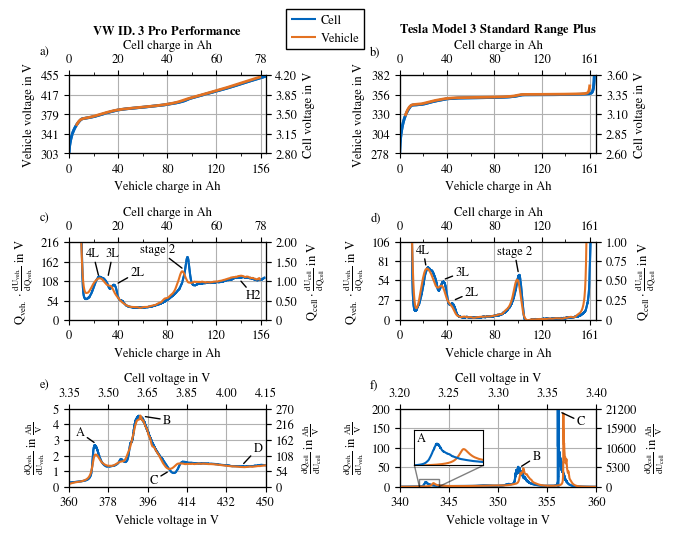

In [57]:
nrows = 2
heigth = 4.5 #cm
fig, axes= plt.subplots(3,2,
                        figsize=(VisualizationConfig.textwidth_in_in.value,
                                3 * cm2inch(heigth)))

axes[0][0] = plot_pOCV_vw(axes[0][0],
          cap_cell = df_cell_vw["Q"], U_cell = df_cell_vw["U"],
          cap_vehicle = df_vw["Q"], U_vehicle  = df_vw["U"],
          lst_Q_shift_factor = deltaQ_vw)

axes[0][1] = plot_pOCV_tesla(axes[0][1],
          cap_cell = df_cell_tesla["Q"], U_cell = df_cell_tesla["U"],
          cap_vehicle = df_tesla["Q"], U_vehicle  = df_tesla["U"],
          lst_Q_shift_factor = deltaQ_tesla)


axes[1][0] = plot_dva_vw(axes = axes[1][0],
                  cap_cell = cap_cell_vw, dva_cell = dva_cell_vw,
                  cap_v = cap_vw, dva_v=dva_vw,
                  shift_factor = deltaQ_vw)

axes[1][1] = plot_dva_tesla(axes = axes[1][1],
                  cap_cell = cap_cell_tesla, dva_cell = dva_cell_tesla,
                  cap_v = cap_tesla, dva_v=dva_tesla,
                  shift_factor = deltaQ_tesla)


axes[2][0] = plot_ica_vw(axes[2][0],
                  volt_cell = volt_cell_vw, ica_cell = ica_cell_vw,
                  volt_v = volt_vw , ica_v = ica_vw)

axes[2][1] = plot_ica_tesla(axes[2][1],
                  volt_cell = volt_cell_tesla, ica_cell = ica_cell_tesla,
                  volt_v = volt_tesla , ica_v = ica_tesla)

# annotations
axes[1][0] = add_FOI_DVA_VW(axes[1][0])
axes[2][0] = add_FOI_ICA_VW(axes[2][0])

axes[1][1] = add_FOI_DVA_T(axes[1][1])
axes[2][1] = add_FOI_ICA_T(axes[2][1])
# legend
handles, labels =axes[1][0].get_legend_handles_labels()  
line2 = plt.hlines(0,0,1,label=r'Cell', color=VisualizationConfig.TUMblau.value)
line3 = plt.hlines(0,0,1,label=r'Vehicle',color=VisualizationConfig.TUMorange.value)
# add manual symbols to auto legend
handles.extend([line2, line3])
fig.legend(handles=handles,loc="center",fontsize=9,ncols=1,handletextpad=0.4,
            framealpha =1 , fancybox=False,labelspacing=0.5,columnspacing=0.7,edgecolor="black",bbox_to_anchor=(0.48,0.96))
plt.tight_layout()

axes[0][0].text(-0.15, 1.3, 'a)', horizontalalignment='left',fontsize=9,
     verticalalignment='center', transform=axes[0][0].transAxes)
axes[0][1].text(-0.15, 1.3, r'b)', horizontalalignment='left',fontsize=9,
     verticalalignment='center', transform=axes[0][1].transAxes)
axes[1][0].text(-0.15, 1.3, r'c)', horizontalalignment='left',fontsize=9,
     verticalalignment='center', transform=axes[1][0].transAxes)
axes[1][1].text(-0.15, 1.3, r'd)', horizontalalignment='left',fontsize=9,
     verticalalignment='center', transform=axes[1][1].transAxes)
axes[2][0].text(-0.15, 1.3, r'e)', horizontalalignment='left',fontsize=9,
     verticalalignment='center', transform=axes[2][0].transAxes)
axes[2][1].text(-0.15, 1.3, r'f)', horizontalalignment='left',fontsize=9,
     verticalalignment='center', transform=axes[2][1].transAxes)
fig.savefig(os.path.join(GeneralConfig.path2figures.value,"04-POCV_DVA_ICA_VW_Tesla.pdf")) 
fig.savefig(os.path.join(GeneralConfig.path2figures.value,"04-POCV_DVA_ICA_VW_Tesla.png"),dpi=300, pad_inches = 0) 